In [9]:
import pandas as pd

# Load the Observations dataset
observations = pd.read_csv("observations.csv")  # Ensure correct file path

# Define relevant vital sign codes (LOINC codes from Synthea dataset)
vital_signs_codes = {
    "Heart Rate": "8867-4",
    "Respiratory Rate": "9279-1",
    "BP Systolic": "8480-6",
    "BP Diastolic": "8462-4",
    "Oxygen Saturation": "2710-2",
    "Temperature": "8310-5"
}

# Filter dataset to keep only vital signs
vital_signs_df = observations[observations["CODE"].isin(vital_signs_codes.values())].copy()

# Convert units if necessary (assuming some temperatures might be in Fahrenheit)
def convert_temperature(value, unit):
    if unit == "F":
        return (float(value) - 32) * 5.0 / 9.0  # Convert to Celsius
    return float(value)  # Already in Celsius

# Fix: Avoid SettingWithCopyWarning by creating a separate copy for temperature rows
if "UNITS" in vital_signs_df.columns:
    temp_rows = vital_signs_df.loc[vital_signs_df["CODE"] == "8310-5"].copy()
    temp_rows["VALUE"] = temp_rows.apply(lambda row: convert_temperature(row["VALUE"], row["UNITS"]), axis=1)
    vital_signs_df.update(temp_rows)  # Safely update the original DataFrame

# Select the most recent measurement per patient for each vital sign
vital_signs_df = vital_signs_df.sort_values(by=["PATIENT", "DATE"], ascending=[True, False])
vital_signs_latest = vital_signs_df.groupby(["PATIENT", "CODE"]).first().reset_index()

# Pivot table to structure vital signs as columns
vital_signs_pivot = vital_signs_latest.pivot(index="PATIENT", columns="CODE", values="VALUE").reset_index()

# Print available column names (Debugging Step)
print("Available columns:", vital_signs_pivot.columns)

# Rename columns based on their codes (use strip() to remove spaces)
vital_signs_pivot.columns = vital_signs_pivot.columns.astype(str).str.strip()  # Ensure no trailing spaces

# Rename using a dictionary
rename_dict = {
    "8867-4": "Heart Rate",
    "9279-1": "Respiratory Rate",
    "8480-6": "BP Systolic",
    "8462-4": "BP Diastolic",
    "2710-2": "Oxygen Saturation",
    "8310-5": "Temperature"
}

# Only rename columns that exist
vital_signs_pivot.rename(columns={k: v for k, v in rename_dict.items() if k in vital_signs_pivot.columns}, inplace=True)

# **Print actual column names after renaming**
print("Renamed columns:", vital_signs_pivot.columns)

# **Fix: Convert all columns to numeric if they exist**
for col in ["Heart Rate", "Respiratory Rate", "BP Systolic", "BP Diastolic", "Oxygen Saturation", "Temperature"]:
    if col in vital_signs_pivot.columns:
        vital_signs_pivot[col] = pd.to_numeric(vital_signs_pivot[col], errors='coerce')

# Define the scoring function based on risk categories
def calculate_vital_sign_score(row):
    score = 0

    # Apply scoring logic safely (Check if column exists before access)
    if "Heart Rate" in row and (row["Heart Rate"] < 50 or row["Heart Rate"] > 120):
        score += 1.0
    elif "Heart Rate" in row and (100 <= row["Heart Rate"] <= 120 or 50 <= row["Heart Rate"] < 60):
        score += 0.5

    if "Respiratory Rate" in row and (row["Respiratory Rate"] < 10 or row["Respiratory Rate"] > 30):
        score += 1.0
    elif "Respiratory Rate" in row and (21 <= row["Respiratory Rate"] <= 30):
        score += 0.5

    if "BP Systolic" in row and (row["BP Systolic"] < 80 or row["BP Systolic"] > 160):
        score += 1.0
    elif "BP Systolic" in row and (80 <= row["BP Systolic"] < 90 or 140 <= row["BP Systolic"] <= 160):
        score += 0.5

    if "Oxygen Saturation" in row and row["Oxygen Saturation"] < 92:
        score += 1.0
    elif "Oxygen Saturation" in row and (92 <= row["Oxygen Saturation"] <= 94):
        score += 0.5

    if "Temperature" in row and (row["Temperature"] < 35 or row["Temperature"] > 38.5):
        score += 1.0
    elif "Temperature" in row and (35 <= row["Temperature"] < 36 or 37.5 <= row["Temperature"] <= 38.5):
        score += 0.5

    return score / 5  # Normalize to range 0-1

# Compute vital signs score only for rows with data
if {"Heart Rate", "Respiratory Rate", "BP Systolic", "BP Diastolic", "Oxygen Saturation", "Temperature"}.intersection(vital_signs_pivot.columns):
    vital_signs_pivot["Vital Signs Score"] = vital_signs_pivot.apply(calculate_vital_sign_score, axis=1)
else:
    print("Warning: No valid vital sign data available for scoring!")

# Save the result
vital_signs_pivot.to_csv("vital_signs_scores.csv", index=False)

# Display final patient-level vital signs score
print("Vital Signs Score calculated and saved to 'vital_signs_scores.csv'")
print(vital_signs_pivot.head())


Available columns: Index(['PATIENT', '8310-5', '8462-4', '8480-6', '8867-4', '9279-1'], dtype='object', name='CODE')
Renamed columns: Index(['PATIENT', 'Temperature', 'BP Diastolic', 'BP Systolic', 'Heart Rate',
       'Respiratory Rate'],
      dtype='object', name='CODE')
Vital Signs Score calculated and saved to 'vital_signs_scores.csv'
CODE                               PATIENT  Temperature  BP Diastolic  \
0     0230d89f-b3fb-585a-cad9-6249f9b95a63         37.3          88.0   
1     0d4783bd-f511-5f7d-58c6-6f7d1ceb56e9         37.0          94.0   
2     0db0a5bf-372f-7a4e-2955-2c1bccc14844          NaN          77.0   
3     0ec6a024-1b15-083a-4425-c0f211f0f51c         37.3          77.0   
4     0f0571ec-ec02-605e-85f4-69812e822433          NaN          94.0   

CODE  BP Systolic  Heart Rate  Respiratory Rate  Vital Signs Score  
0           138.0        80.0              14.0                0.0  
1           118.0        81.0              12.0                0.0  
2           

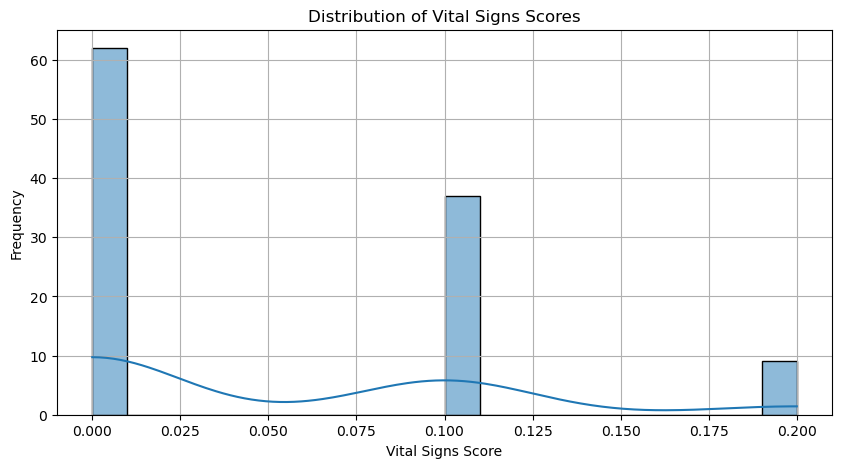

In [13]:
# Re-import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the vital signs pivot dataframe exists
if 'vital_signs_pivot' in locals():
    # Remove NaN values from the "Vital Signs Score" column
    vital_signs_pivot = vital_signs_pivot.dropna(subset=["Vital Signs Score"])

    # Plot distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(vital_signs_pivot["Vital Signs Score"], bins=20, kde=True)
    plt.xlabel("Vital Signs Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Vital Signs Scores")
    plt.grid(True)

    # Show the plot
    plt.show()
else:
    print("Error: The vital_signs_pivot dataframe does not exist. Please ensure the previous computation was successful.")
